# INF 552 Assignment 4

## Perceptron, Linear & Logistic Regression

Author: 

Zongdi Xu (USC ID 5900-5757-70, working on Percepron, Pocket & Logistic Regression), 

Wenkai Xu (USC ID 5417-1457-73, working on Linear Regression).

Date: Mar 22, 2019


## Part 1

### 1.1 Perceptron Learning algorithm

- Read data from file

In [1]:
import numpy as np
import time

def read_data(filename):
    input_f=open(filename, 'r')
    input_data=[]
    for line in input_f.readlines():
        input_data.append([float(val) for val in line.split(',')])
    input_data=np.array(input_data)
    train_x=input_data[:,:-2]
    train_y=input_data[:,-2:-1]
    train_x=np.concatenate((train_x, np.ones((train_x.shape[0],1))),axis=1)
    n, dimension = train_x.shape
    return n, dimension, train_x, train_y
    
n, dimension, train_x, train_y = read_data('classification.txt')
train_x, train_y.T

(array([[0.750072  , 0.97740794, 0.88565752, 1.        ],
        [0.87791369, 0.01925101, 0.50671112, 1.        ],
        [0.7773246 , 0.99406596, 0.82224385, 1.        ],
        ...,
        [0.5155064 , 0.15354364, 0.01275495, 1.        ],
        [0.2282263 , 0.97155357, 0.18305906, 1.        ],
        [0.36391513, 0.49207061, 0.71952659, 1.        ]]),
 array([[-1.,  1., -1., ...,  1., -1., -1.]]))

- Perceptron training and predicting

    For the reason that error can occur when doing floating-point number equality comparison, here we define approximation values of `zero` for further use.

In [2]:
pos_zero_threshold = 1e-7
neg_zero_threshold = -1e-7

Use sign function as `activation function` for perceptron.

In [3]:
def activate(val, threshold = neg_zero_threshold):
    activation_func = np.vectorize(lambda x: 1.0 if x > threshold else -1.0)
    return activation_func(val)

def predict(n, train_x, train_y, W):
    output=[activate(np.sum(train_x[i,:]*W)*train_y[i,:]) for i in range(n)]
    return np.array(output).reshape(-1,1)

def get_accuracy(n, hypothesis, train_y):
    return (np.abs(hypothesis-train_y)<pos_zero_threshold).sum().astype('float')/n

def perceptron(n, dimension, train_x, train_y, max_epoch, learning_rate):
    weight=np.ones((1,dimension))*-1.0

    for epoch in range(max_epoch):
        # feed-forward
        hypothesis=predict(n, train_x, train_y, weight)

        accuracy = get_accuracy(n, hypothesis, train_y)
        
        # gradient descent
        delta = hypothesis*learning_rate*train_x        
        if (np.abs(hypothesis-train_y)<pos_zero_threshold).sum()==n:
            break

        weight-=np.dot(delta.T,train_y).T

    return weight, accuracy, hypothesis, epoch

start_time = time.time()
weight, accuracy, prediction, epoch = perceptron(n, dimension, train_x, train_y, max_epoch=5000, learning_rate=1e-6)
print 'After %d epoch(s), %.3f s elapsed:'% (epoch, time.time()-start_time)
print 'Weight matrix =', weight
print 'Accuracy rate=%.2f' % accuracy

After 2541 epoch(s), 144.596 s elapsed:
Weight matrix = [[-0.000545   -0.00054431 -0.00064126  0.002464  ]]
Accuracy rate=1.00


Here comes the prediction output, and we can confirm that the output is exactly the same with expected.

In [5]:
result = predict(n, train_x, train_y, weight)
result.T, (result == train_y).sum()

(array([[-1.,  1., -1., ...,  1., -1., -1.]]), 2000)

- Optimization

    Later we came up with a method of optimization. We found that replacing "for" iteration with `numpy` dot product can accelerate the training process. It might be due to the internal parellel computing implementation of dot product. It saves much time.

In [6]:
def predict(n, train_x, train_y, W):
    return activate(np.dot(train_x, W.reshape(-1,1))*train_y)

def get_accuracy(n, hypothesis, train_y):
    return (np.abs(hypothesis-train_y)<pos_zero_threshold).sum().astype('float')/n

def perceptron(n, dimension, train_x, train_y, max_epoch, learning_rate):
    weight = np.array([-1.0]*dimension)

    for epoch in range(max_epoch):
        # feed-forward
        hypothesis=predict(n, train_x, train_y, weight)

        accuracy = get_accuracy(n, hypothesis, train_y)
        
        delta = hypothesis*learning_rate*train_x

        # gradient descent
        if (np.abs(hypothesis-train_y)<pos_zero_threshold).sum()==n:
            break

        weight-=np.squeeze(np.dot(delta.T,train_y).T)

    return weight, accuracy, hypothesis, epoch

start_time = time.time()
weight, accuracy, prediction, epoch = perceptron(n, dimension, train_x, train_y, max_epoch=5000, learning_rate=1e-6)
print 'After %d epoch(s), %.3f s elapsed:'% (epoch, time.time()-start_time)
print 'Weight matrix =', weight
print 'Accuracy rate=%.2f' % accuracy

After 2541 epoch(s), 0.859 s elapsed:
Weight matrix = [-0.000545   -0.00054431 -0.00064126  0.002464  ]
Accuracy rate=1.00


While the result remains the same, much time would be saved in this way.

### 1.2 Pocket algorithm

Compared to Perceptron, the outline of this program remains the same, meanwhile it will keep records of every possible solution that occurs in every iteration.

In [9]:
def pocket(n, dimension, train_x, train_y, max_epoch, learning_rate):
    weight = np.array([-1.0]*dimension)
    misclassification = []

    best_match = 0
    best_weight = None
    
    for epoch in range(max_epoch):
        hypothesis=predict(n, train_x, train_y, weight)*train_y
        
        delta = hypothesis*learning_rate*train_x
     
        match = (np.abs(predict(n, train_x, train_y, weight)-train_y)<pos_zero_threshold).sum()
        
        accuracy = 1.0*match/n
    
        if match > best_match:
            best_match = match
            best_weight = weight[:]
    
        if match==n:
            break

        weight-=np.squeeze(np.dot(delta.T,train_y).T)
        
        misclassification.append(n - match)
        
        # print 'Epoch #%d, accuracy_rate=%.3f' % (epoch, accuracy)

    return best_weight, 1.0*best_match/n, predict(n, train_x, train_y, best_weight), epoch, misclassification

weight, accuracy, prediction, epoch, misclassification = pocket(n, dimension, train_x, train_y, max_epoch=7000, learning_rate=1e-6)
print 'After %d epoch(s), %.3f s elapsed:'% (epoch, time.time()-start_time)
print 'Weight matrix =', weight
print 'Accuracy rate=%.2f' % accuracy

After 6999 epoch(s), 491.101 s elapsed:
Weight matrix = [-0.00158062 -0.00159346 -0.00167577  0.00021   ]
Accuracy rate=0.68


Plot the numbers of misclassified points against the number of iterations:

[]

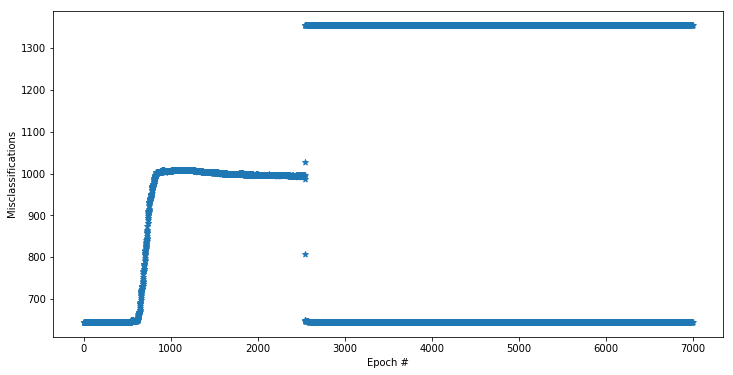

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(range(len(misclassification)), misclassification, marker='*')
plt.xlabel('Epoch #')
plt.ylabel('Misclassifications')
plt.plot()

We noticed abnormal fluctuations after numerous epochs.

### 1.3 Logistic Regression

- Read data from file:

In [13]:
def read_data(filename):
    input_f=open(filename, 'r')
    input_data=[]
    for line in input_f.readlines():
        input_data.append([float(val) for val in line.split(',')])
    input_data=np.array(input_data)
    train_x=input_data[:,:-2]
    train_y=input_data[:,-1]
    train_x=np.concatenate((train_x, np.ones((train_x.shape[0],1))),axis=1)
    n, dimension = train_x.shape
    return n, dimension, train_x, train_y.reshape(-1,1)
    
n, dimension, X, y = read_data('classification.txt')
y = np.squeeze(y)
y = (y+1.1).astype('int')/2
X, y

(array([[0.750072  , 0.97740794, 0.88565752, 1.        ],
        [0.87791369, 0.01925101, 0.50671112, 1.        ],
        [0.7773246 , 0.99406596, 0.82224385, 1.        ],
        ...,
        [0.5155064 , 0.15354364, 0.01275495, 1.        ],
        [0.2282263 , 0.97155357, 0.18305906, 1.        ],
        [0.36391513, 0.49207061, 0.71952659, 1.        ]]),
 array([1, 0, 1, ..., 1, 1, 1]))

As for `sigmoid` function, we modified the original form: 
$$\theta(s)=\frac{e^s}{1+e^s}$$

According to $\theta(-s)=1-\theta(s)$, we can prevent the duplicate calculation of $e^s$, making it more efficient.
$$\theta(s)=\frac{1}{1+e^{-s}}$$

In [16]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=10000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
    
    def sigmoid(self, val):
        return 1 / (1 + np.exp(-val))
    
    def fit(self, X, y):
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        # gradient descent
        for i in range(self.max_iter):
            hypothesis = self.sigmoid(np.dot(X, self.theta))
            gradient = np.dot(X.T, (hypothesis - y)) / y.size
            self.theta -= self.learning_rate * gradient

        return i

    
    def predict(self, X):
        return self.sigmoid(np.dot(X, self.theta)).round()

In [17]:
model = LogisticRegression(0.1, 70000)

start_time = time.time()
epoch=model.fit(X, y)
print 'After %d epoch(s), %.3f s elapsed:'% (epoch, time.time()-start_time)

prediction = model.predict(X).astype('int')

print 'Weight matrix=', model.theta
print 'accuracy_rate=', (prediction==y).sum()*1.0/len(prediction)

After 69999 epoch(s), 2.531 s elapsed:
Weight matrix= [-0.17769619  0.11445235  0.07670126 -0.03150075]
accuracy_rate= 0.5295


### 1.4 Linear Regression

In [18]:
import numpy as np
import pandas as pd

data = pd.read_csv('linear-regression.txt',names=["X","Y","Z"])      
print(data.shape)
data.head()

(3000, 3)


,X,Y,Z
0,0.693781,0.697544,3.252290
1,0.693737,0.575576,2.898651
2,0.000576,0.458192,1.986979
3,0.194953,0.470199,2.272075
4,0.031775,0.026546,0.231178


In the `linear-regression.txt` given dataset, there are at total 3 different variables: X,Y and Z.

X and Y are the independent variables and Z is the dependent variable. Based on the linear regression, we should finally have a form of $Z=a0+a1*X+a2*Y$.

In [19]:
X = data['X'].values
Y = data['Y'].values
Z = data['Z'].values
# X and Y are the independent variables and Z is the dependent variable 
# Z=a0+a1X+a2Y

In [20]:
l = len(X)
X0 = np.array([np.ones(l), X, Y]).T     # Here I put the first column as all "1"s because the a0 is the intercept, there is no corresponding x
Coefficient = np.array([0, 0, 0])       # Here are the coefficients. There are 3 entries: the 1st is intercept, the 2nd is X's coefficient and 3rd is Y's coefficient
# Coefficient = np.zeros((1,3))
Y0 = np.array(Z)                        # Actual value of Z
X0

array([[1.00000000e+00, 6.93780796e-01, 6.97543511e-01],
       [1.00000000e+00, 6.93737070e-01, 5.75575902e-01],
       [1.00000000e+00, 5.75595955e-04, 4.58192235e-01],
       ...,
       [1.00000000e+00, 1.53260958e-01, 4.28193331e-01],
       [1.00000000e+00, 6.04550350e-01, 8.62078270e-01],
       [1.00000000e+00, 2.12577119e-01, 1.15651970e-01]])

In this implementation, I choose to use gradient descent algorithm to find the coefficient of a0,a1 and a2.
The cost function J(a0,a1,a2) is computed and I update the coefficient a0,a1,a2 based on the partial derivative of cost function J every iteration. 

The updating equation is:
$C=c - {learning\_rate}* \frac{d}{dax(J)}$.

I predefine the learning rate as 0.001 and set iteration 7000 times.

Here is my gradient descent function:

In [21]:
## Here is the cost function:
#  J=sigma(h0(xi)-yi)^2/2m
## The gradient is the partial derivative of J: gradient= sigma(h0(xi)-yi)*xi
## Then we update the coefficient every iteration.
def gradient_descent(X, Y, C, learning_rate, iterations):
    l = len(Y)    
    for iteration in range(iterations):
        H = X.dot(C)  # H is the hypothesis value (X bar) 
        delta_x = H - Y # delta_x is the difference between hypothesis value and actural value of Z       
        gradient = X.T.dot(delta_x) / l  # Here is the gradient   
        C = C - learning_rate * gradient   # We update the coefficient by subtracting learning rate multipled by the partial derivative of cost func
#         print iteration, C, np.sum(delta_x**2)
    return C, iteration, np.sum(delta_x**2)

My final coefficients after 7000 iterations is:

In [23]:
# 7000 Iterations with learning rate of 0.001
Coefficients, iteration, square_error = gradient_descent(X0, Y0, Coefficient, 0.001, 7000)

# Intercept a0, Coefficient of X: a1, Coefficient of Y:a2
print 'Epoch #',iteration, Coefficients

Epoch # 6999 [1.20456537 0.76637821 2.04944651]


Thus, the fitted equation of given data is $Z=1.2046+0.76638X+2.04944Y$.

### 1.5 Additional description

* The challenges we have faced: 

    After implementing the linear regression and logistics regression model, we run 7000 iterations with learning rate of 0.001 and finally we got the coefficients. But we are not sure that whether our answer is accurate or not. Plus, we want to find a way to assess our result and improve the accuracy.


* Ways to improve:

    Root Mean Square Error (RMSE) and R square are two major values to assess our model. We can try to add them to our implementation: low value of RMSE and high value of R^2 means that our model is good.

## Part 2 Software Familiarization

### 2.1 Perceptron Learning

In [ ]:
from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron
X, y = load_digits(return_X_y=True)
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X, y)
clf.score(X, y)

### 2.2 Logistic Regression

We can use the logistic regression function from `sk-learn` package.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(fit_intercept=True, C = 1e15)clf.fit(simulated_separableish_features, simulated_labels)
print clf.intercept_, clf.coef_

### 2.3 Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# X and Y Values
X = np.array([math, read]).T
Y = np.array(write)

# Model Intialization
reg = LinearRegression()

# Data Fitting
reg = reg.fit(X, Y)

# Y PredictionY_
pred = reg.predict(X)

# Model Evaluation
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = reg.score(X, Y)print(rmse)print(r2)

## Part 3 Application

The Perceptron Learning algorithm is a basis of neural network. It can be used for binary classification problems (Yes or No) such as sentiment analysis.

The targeted variable of linear regression is continuous. Linear regressions can be used in business to evaluate trends and make estimates or forecasts.

For logistic regression, it is a generalized linear model and the dependent variable is discrete.  It may be used to predict the risk of developing a given disease based on observed characteristics of the patient (age, sex, blood test and etc.).


## Part 4 References

- https://en.wikipedia.org/wiki/Logistic_regression
- https://mubaris.com/posts/linear-regression/
- https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24
- https://machinelearningmastery.com/implement-perceptron-algorithm-scratch-python/
- https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac
- Documents of `numpy` library
- Documents of `sklearn` library
- Documents of `matplotlib` library
